In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import re
import spacy
spacy.cli.download('es_core_news_lg')
nlp = spacy.load('es_core_news_lg')
import  nltk
print(nltk.__version__)

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
3.7


In [3]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
import keras.utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalMaxPool1D
from keras.layers import LSTM
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras import Model
from keras.utils import to_categorical
from keras.utils import pad_sequences 

#Importing the spanish song dataset

In [5]:
with open ('/content/drive/MyDrive/Progetto_TA_2022/pickled_df/df_es.pkl', mode='br') as inputfile:
  df_es = pickle.load(inputfile)

In [6]:
df_es.head()

,Artist,Song,Genre,Language,Lyrics
1074,aerosmith,i don't want to miss a thing (traducción),Rock,es,podría permanecer despierto sólo para escuchar...
1093,aerosmith,ain't that a bitch (traducción),Rock,es,esfumado has perdido otro amante mientras le d...
1096,aerosmith,amazing (traducción),Rock,es,yo rechazaba las cosas correctas y aceptaba la...
1158,aerosmith,fly away from here (traducción),Rock,es,tengo que encontrar un camino sí no puedo espe...
1181,aerosmith,i don't want to miss a thing (traducción),Rock,es,podría permanecer despierto sólo para escuchar...


In [7]:
df_es.shape

(3892, 5)

In [8]:
df_es = df_es.reset_index()
df_es = df_es.drop(['index'], axis = 1)

In [9]:
df_es.head()

,Artist,Song,Genre,Language,Lyrics
0,aerosmith,i don't want to miss a thing (traducción),Rock,es,podría permanecer despierto sólo para escuchar...
1,aerosmith,ain't that a bitch (traducción),Rock,es,esfumado has perdido otro amante mientras le d...
2,aerosmith,amazing (traducción),Rock,es,yo rechazaba las cosas correctas y aceptaba la...
3,aerosmith,fly away from here (traducción),Rock,es,tengo que encontrar un camino sí no puedo espe...
4,aerosmith,i don't want to miss a thing (traducción),Rock,es,podría permanecer despierto sólo para escuchar...


#Splitting the dataset in training set and test set

In [10]:
import sklearn
from sklearn.model_selection import train_test_split

In [11]:
es_train, es_test = sklearn.model_selection.train_test_split(df_es, test_size=0.20, train_size=0.80)

In [12]:
es_train.shape, es_test.shape

((3113, 5), (779, 5))

In [13]:
df_es['Genre'].value_counts() 

Pop           3042
Rock           755
Metal           65
Indie           10
Folk             8
Jazz             6
Electronic       3
R&B              2
Hip-Hop          1
Name: Genre, dtype: int64

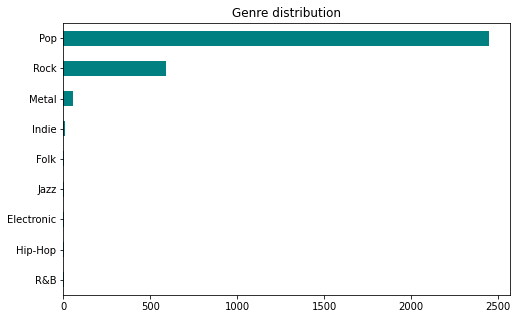

In [14]:
plt.rcParams['figure.figsize'] = [8,5]
x = es_train['Genre'].value_counts().sort_values(ascending = True)
plt.title("Genre distribution")
x.plot(kind ='barh', color="teal")

#Tokenizing the lyrics with spacy

In [15]:
x_train = es_train['Lyrics'].tolist()
y_train = es_train['Genre'].tolist()

In [16]:
x_test = es_test['Lyrics'].tolist()
y_test = es_test['Genre'].tolist()

In [17]:
len(x_train), len(y_train), len(x_test), len(y_test)

(3113, 3113, 779, 779)

In [18]:
set(y_train)

{'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Metal',
 'Pop',
 'R&B',
 'Rock'}

In [19]:
sample_idx = 15
x_train[sample_idx]

'dame una esperanza vida que me muero de esperar dame una esperanza vida que me muero de esperar tan solo una migajita de tu amor para no llorar que mi corazon esta enfermo y solo tu lo puedes curar que mi corazon esta enfermo y solo tu lo puedes curar eres mi medicina mi antidoto y vitamina sin ti soy alma perdida y tus besos son mi adrenalina eres mi medicina mi mi mi vitamina sin ti no tengo vida dame una salida dame de lo que yo quiero que me estoy poniendo mal dame de lo que yo quiero que me estoy poniendo mal quisiera una sobredosis de carino para sanar que mi corazon esta enfermo y solo tu lo puedes curar que mi corazon esta enfermo y solo tu lo puedes curar eres mi medicina mi antidoto y vitamina sin ti soy alma perdida y tus besos son mi adrenalina eres mi medicina mi mi mi vitamina sin ti no tengo vida dame una salida eres mi medicina mi mi mi vitamina sin ti no tengo vida dame una salida eres mi medicina mi vitamina la que me da vida la que me fascina solo quiero enloquecert

In [20]:
y_train[sample_idx]

'Pop'

In [21]:
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

stopword_list = stopwords.words('spanish')
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [22]:
def spacy_tokenizer (text):
   
    doc = nlp(text)

    #lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]

    #removing stopwords and punctuations
    lemmas_stop= [token for token in lemmas if token not in stopword_list and token not in punctuations]  

    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_stop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_stop,3)] 
    
    all_tokens = list()
    all_tokens.extend(lemmas_stop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

#Token vectorization with CountVectorizer and spacy_tokenizer function above

In [23]:
vectors = CountVectorizer (analyzer = spacy_tokenizer, min_df = 10)

In [24]:
print ('fit')
vectors.fit(x_train)
print('transform')
x_train_tok = vectors.transform(x_train)
x_test_tok = vectors.transform(x_test)
print ('done')

fit
transform
done


In [25]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/es_x_train_tok.pkl', 'wb') as outfile:
  pickle.dump(x_train_tok, outfile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/es_x_test_tok.pkl', 'wb') as outfile:
  pickle.dump(x_test_tok, outfile)

In [26]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/es_x_train_tok.pkl', mode = 'br') as infile:
  x_train_tok = pickle.load(infile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/es_x_test_tok.pkl', mode = 'br') as infile:
  x_test_tok = pickle.load(infile)

In [27]:
len(vectors.vocabulary_)

4031

In [28]:
vectors.vocabulary_

{'baby': 1923,
 'is': 2857,
 'seducir': 3652,
 'saber': 3614,
 'ser': 3677,
 'besar': 1959,
 'rico': 3576,
 'allá': 1797,
 'chico': 2096,
 'i': 2795,
 'so': 3713,
 'you': 4018,
 'and': 1830,
 'that': 3819,
 'right': 3577,
 'tener': 3807,
 'cama': 2037,
 'fuego': 2661,
 'amor': 1827,
 'dormir': 2438,
 'poder': 3374,
 'mas': 3018,
 'importar': 2813,
 'engaño': 2501,
 'extraño': 2590,
 'pasión': 3285,
 'respiración': 3556,
 'labio': 2893,
 'sur': 3772,
 'ombligo': 3222,
 'BI_tener_tener': 1476,
 'BI_amor_poder': 74,
 'BI_poder_mas': 907,
 'BI_mas_mas': 696,
 'felicidad': 2613,
 'dont': 2435,
 'back': 1924,
 'ojo': 3206,
 'encontrar': 2485,
 'palabra': 3253,
 'mano': 3004,
 'corazón': 2205,
 'sonrisa': 3736,
 'ilusión': 2807,
 'fe': 2611,
 'atrapado': 1895,
 'red': 3521,
 'vencer': 3930,
 'coro': 2208,
 'alcanzar': 1776,
 'amar': 1812,
 'verdad': 3948,
 'si': 3692,
 'entrega': 2515,
 'razón': 3504,
 'vivir': 3977,
 'quién': 3486,
 'dar': 2277,
 'liberar': 2922,
 'imaginación': 2809,
 'x': 

#SVM Classification 

---



---



Classification report:
              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         2
       Indie       0.00      0.00      0.00         2
        Jazz       0.00      0.00      0.00         1
       Metal       0.67      0.17      0.27        12
         Pop       0.83      0.96      0.89       597
         R&B       0.00      0.00      0.00         1
        Rock       0.66      0.35      0.46       163

    accuracy                           0.81       779
   macro avg       0.27      0.18      0.20       779
weighted avg       0.79      0.81      0.78       779

Confusion matrix:
[[  0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   1   0   1]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   2   5   0   5]
 [  0   0   0   0   1 574   0  22]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0 106   0  57]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


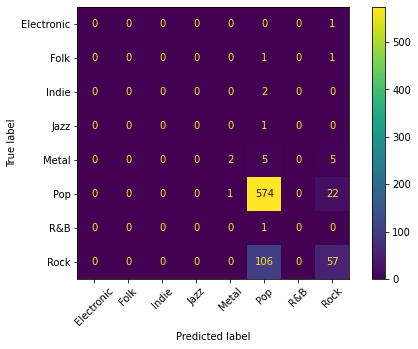

In [30]:
svm_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train,y_train)
predictions = svm_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics - no optimization

Classification report:
              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         2
       Indie       0.00      0.00      0.00         2
        Jazz       0.00      0.00      0.00         1
       Metal       0.75      0.25      0.38        12
         Pop       0.83      0.95      0.89       597
         R&B       0.00      0.00      0.00         1
        Rock       0.65      0.37      0.47       163

    accuracy                           0.81       779
   macro avg       0.28      0.20      0.22       779
weighted avg       0.79      0.81      0.79       779

Confusion matrix:
[[  0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   3   7   0   2]
 [  0   0   0   0   1 569   0  27]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0 103   0  60]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


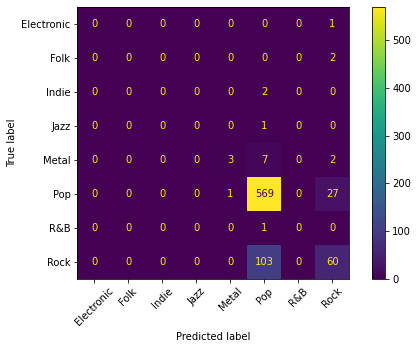

In [31]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train_tok,y_train)
predictions = svm_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test_tok, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics and optimized parameters


In [32]:
opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

param_grid = [{'sel__k': [1000, 2000, 3000,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=None, n_jobs = 3, verbose=True).fit(x_train_tok,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [33]:
SVM_opt_search.best_params_

{'learner__C': 1, 'sel__k': 'all'}

In [34]:
SVM_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x7fc36419e200>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=1))])

In [37]:
opt_predictions = SVM_opt_search.best_estimator_.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         2
       Indie       0.00      0.00      0.00         2
        Jazz       0.00      0.00      0.00         1
       Metal       0.75      0.25      0.38        12
         Pop       0.84      0.96      0.89       597
         R&B       0.00      0.00      0.00         1
        Rock       0.67      0.38      0.49       163

    accuracy                           0.82       779
   macro avg       0.28      0.20      0.22       779
weighted avg       0.79      0.82      0.79       779

Confusion matrix:
[[  0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   3   7   0   2]
 [  0   0   0   0   1 571   0  25]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0 101   0  62]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features that weight more on classification:

In [38]:
tokenizer = vectors
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [39]:
feature_names = tokenizer.get_feature_names_out()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

4031

In [40]:
feats_w_score[:100],feats_w_score[-100:]

([(0.2519264356380921, False, 'presa'),
  (0.2876222848615487, False, 'BI_dejar_pasar'),
  (0.2876222848615487, False, 'BI_ir_crecer'),
  (0.2876222848615487, False, 'BI_ser_complicado'),
  (0.2876222848615487, False, 'BI_ser_conocer'),
  (0.2876222848615487, False, 'BI_ser_tonto'),
  (0.2876222848615487, False, 'BI_si_gente'),
  (0.2876222848615487, False, 'pila'),
  (0.2876222848615487, False, 'podrir'),
  (0.3629039315389011, False, 'BI_alma_ir'),
  (0.3629039315389011, False, 'BI_canción_ser'),
  (0.3629039315389011, False, 'BI_corazón_decir'),
  (0.3629039315389011, False, 'BI_dejar_huella'),
  (0.3629039315389011, False, 'BI_ser_entender'),
  (0.3629039315389011, False, 'BI_si_acercar'),
  (0.3629039315389011, False, 'BI_silencio_hablar'),
  (0.3629039315389011, False, 'BI_soledad_ser'),
  (0.3629039315389011, False, 'BI_tarde_ser'),
  (0.3629039315389011, False, 'alzar'),
  (0.3629039315389011, False, 'brotar'),
  (0.3629039315389011, False, 'contar él'),
  (0.3629039315389011, 

In [41]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

2516

In [42]:
feats_w_classifier_weight[:100]

[(-0.22312969412737416, 'arriba'),
 (-0.16953146785968934, 'i'),
 (-0.16217211197118955, 'ser'),
 (-0.1382558070065147, 'haber'),
 (-0.1279474612572398, 'the'),
 (-0.12402008231711042, 'BI_querer_dar'),
 (-0.10981017650183743, 'querer'),
 (-0.10836770806377828, 'ir'),
 (-0.10799583544349062, 'so'),
 (-0.10365156369661413, 'up'),
 (-0.09669799681107516, 'love'),
 (-0.09653238098287995, 'dar'),
 (-0.09277658528053283, 'BI_noche_día'),
 (-0.09247384846669197, 'be'),
 (-0.08976337205801123, 'tener'),
 (-0.0892615734494977, 'amor'),
 (-0.0828792447043804, 'hacer'),
 (-0.07947624122244619, 'hey'),
 (-0.0784673249352612, 'do'),
 (-0.07776190892550515, 'si'),
 (-0.07732090300916639, 'ver'),
 (-0.07646629621081284, 'parar'),
 (-0.07399412407885948, 'like'),
 (-0.07362348742059077, 'día'),
 (-0.07262168207538502, 'don'),
 (-0.07149952871068414, 'noche'),
 (-0.07063120489465399, 'BI_i_love'),
 (-0.06731713989332105, 'ahora'),
 (-0.06421482190345001, 'pa'),
 (-0.063962236419526, 'baila'),
 (-0.062

#Naïve Bayes Classification

---



---



In [44]:
NBC_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(x_train_tok,y_train)
predictions = NBC_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         2
     Hip-Hop       0.00      0.00      0.00         0
       Indie       0.00      0.00      0.00         2
        Jazz       0.50      1.00      0.67         1
       Metal       0.32      0.50      0.39        12
         Pop       0.87      0.86      0.86       597
         R&B       0.00      0.00      0.00         1
        Rock       0.50      0.49      0.50       163

    accuracy                           0.77       779
   macro avg       0.24      0.32      0.27       779
weighted avg       0.77      0.77      0.77       779

Confusion matrix:
[[  0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0]
 [  0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   6   1   0   5]
 [  0   0   1   0   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

#Decision Tree Classification 

---



---



In [46]:
dt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_pipeline.fit(x_train_tok,y_train)
predictions = dt_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         2
       Indie       0.00      0.00      0.00         2
        Jazz       0.33      1.00      0.50         1
       Metal       0.17      0.17      0.17        12
         Pop       0.85      0.88      0.87       597
         R&B       0.00      0.00      0.00         1
        Rock       0.53      0.45      0.49       163

    accuracy                           0.78       779
   macro avg       0.23      0.31      0.25       779
weighted avg       0.77      0.78      0.77       779

Confusion matrix:
[[  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   1]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   1   0   0   0   0]
 [  0   0   0   0   2   6   0   4]
 [  1   0   0   2   6 527   0  61]
 [  0   0   0   0   0   1   0   0]
 [  3   0   0   0   4  82   0  74]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Random Forest Classification
---




In [47]:
RF_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier())  # learning algorithm
])

RF_pipeline.fit(x_train_tok,y_train)
predictions = RF_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00         1
        Folk       0.00      0.00      0.00         2
       Indie       0.00      0.00      0.00         2
        Jazz       1.00      1.00      1.00         1
       Metal       0.67      0.17      0.27        12
         Pop       0.82      0.99      0.90       597
         R&B       0.00      0.00      0.00         1
        Rock       0.96      0.32      0.48       163

    accuracy                           0.83       779
   macro avg       0.43      0.31      0.33       779
weighted avg       0.85      0.83      0.80       779

Confusion matrix:
[[  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   1   0   0   0   0]
 [  0   0   0   0   2  10   0   0]
 [  0   0   0   0   1 594   0   2]
 [  0   0   0   0   0   1   0   0]
 [  1   0   0   0   0 110   0  52]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#LSTM Classification 

---




In [48]:
es_train['Genre_number'] = es_train['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in es_train['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  if i == 'Indie':
   numbers.append(5)

  if i == 'R&B':
    numbers.append(6)
  
  if i == 'Electronic':
    numbers.append(7)
  
  elif i == 'Hip-Hop':
    numbers.append(8)
  

In [49]:
es_train['Genre_number'] = numbers

In [50]:
es_test['Genre_number'] = es_test['Genre'] #converting the strings into int in the Genre column

numbers_test = []
for i in es_test['Genre']:
  if i == 'Rock':
    numbers_test.append(0)
  
  if i == 'Pop':
    numbers_test.append(1)
   
  if i == 'Metal':
    numbers_test.append(2)
    
  if i == 'Jazz':
    numbers_test.append(3)

  if i == 'Folk':
   numbers_test.append(4)
  
  if i == 'Indie':
   numbers_test.append(5)

  if i == 'R&B':
    numbers_test.append(6)
  
  if i == 'Electronic':
    numbers_test.append(7)
  
  elif i == 'Hip-Hop':
    numbers_test.append(8)

In [51]:
es_test['Genre_number'] = numbers_test

In [52]:
es_train.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
3010,thalia,si alguna vez,Pop,es,si alguna vez tuve el amor en contra si caminé...,1
3826,becky g,todo cambio,Pop,es,no lo esperaba no lo buscaba solo se que se di...,1
1127,camila,bésame,Pop,es,besame a destiempo sin piedad y en silencio be...,1
2936,thalia,la risa de las vocales,Pop,es,el palacio el palacio del rey número non se en...,1
989,belinda,ni freud ni tu mamá,Pop,es,sácame del aire no puedo respirar somos difere...,1


In [53]:
es_test.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
2195,paulina rubio,lo siento mi amor (con rocio jurado),Pop,es,lo siento mi amor pero hoy te lo voy a decir a...,1
1969,ov7,azul,Pop,es,luna azul azul dip dirip dirip luna azul azul ...,1
3182,zeze di camargo e luciano,corazón en pedazos,Pop,es,hoy te busco como el mar busca siempre las are...,1
572,calle 13,esto con eso,Rock,es,este es calle mamita esto es para ti tiembla l...,0
576,calle 13,gordita,Rock,es,esto a ti te va a calentar ¿qué a calentar ¿qu...,0


In [54]:
y_train = es_train['Genre_number'] #substituting the columns in the variables
y_test = es_test['Genre_number']

In [55]:
y_train = to_categorical(y_train,9)  #converting to one-hot vectors
y_test = to_categorical(y_test, 9)

In [56]:
y_train.shape, y_test.shape

((3113, 9), (779, 9))

In [57]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [58]:
X_train_final.shape, y_train.shape

((3113, 200), (3113, 9))

In [59]:
X_test_final.shape, y_test.shape

((779, 200), (779, 9))

In [60]:
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(LSTM(20, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 20)                11920     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 297       
                                                                 
Total params: 2,572,889
Trainable params: 2,572,889
Non-

In [61]:
lstm = model.fit(X_train_final, y_train,
                 batch_size=batch_size, 
                 epochs=epochs, 
                 shuffle = True, 
                 validation_split=0.2, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
lstm

Epoch 1/10
39/39 [==============================] - 15s 292ms/step - loss: 1.4905 - accuracy: 0.7494 - val_loss: 0.7760 - val_accuracy: 0.7897
Epoch 2/10
39/39 [==============================] - 11s 280ms/step - loss: 0.7599 - accuracy: 0.7843 - val_loss: 0.6338 - val_accuracy: 0.7897
Epoch 3/10
39/39 [==============================] - 11s 284ms/step - loss: 0.6910 - accuracy: 0.7843 - val_loss: 0.6121 - val_accuracy: 0.7897
Epoch 4/10
39/39 [==============================] - 13s 328ms/step - loss: 0.6817 - accuracy: 0.7843 - val_loss: 0.6060 - val_accuracy: 0.7897
Epoch 5/10
39/39 [==============================] - 11s 271ms/step - loss: 0.6718 - accuracy: 0.7843 - val_loss: 0.6032 - val_accuracy: 0.7897
Epoch 6/10
39/39 [==============================] - 11s 272ms/step - loss: 0.6671 - accuracy: 0.7843 - val_loss: 0.6020 - val_accuracy: 0.7897
Epoch 7/10
39/39 [==============================] - 13s 331ms/step - loss: 0.6635 - accuracy: 0.7843 - val_loss: 0.6007 - val_accuracy: 0.7897

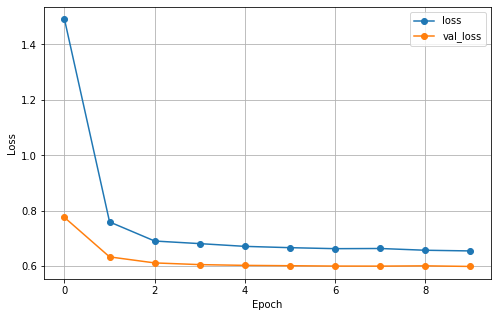

In [62]:
plt.plot(lstm.history['loss'], label='loss', marker = 'o')
plt.plot(lstm.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM Classification

In [63]:
lstm_pred = np.round(model.predict(X_test_final))

25/25 [==============================] - 1s 25ms/step


In [64]:
print('Accuracy %s' % accuracy_score(y_test, lstm_pred))
print('F1-score %s' % f1_score(y_test, lstm_pred, zero_division=1, average=None))
print('Classification report:')
print(classification_report(y_test, lstm_pred, zero_division=1))

Accuracy 0.766367137355584
F1-score [0.         0.86773256 0.         0.         0.         0.
 0.         0.         1.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       163
           1       0.77      1.00      0.87       597
           2       1.00      0.00      0.00        12
           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00         2
           5       1.00      0.00      0.00         2
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00         1
           8       1.00      1.00      1.00         0

   micro avg       0.77      0.77      0.77       779
   macro avg       0.97      0.22      0.21       779
weighted avg       0.82      0.77      0.67       779
 samples avg       0.77      0.77      0.77       779



#CNN Classification 

In [65]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 20
filters = 10
kernel_size = 3
hidden_dims = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [66]:
X_train_final[0]

array([    0,     0,     0,     0,     0,     0,     0, 12122,    54,
       17361,   162,  9880,    54, 12122,   424,  3120,     3,  5737,
         126,  5738,    51,    27,  3858,    10,     5,  3120,   424,
        3120, 17362,     3,    71,     1,  1026,   523,   632,    21,
         144,   883,   119,   527,   132,    21,   144,  6284,     2,
         317,   495,     2,  1190,     2,     2,     2,   495,     2,
        1190,     6,   150,     6,   150,     5,   386,  8136,    10,
           7,   195,     4,    12,    19,     3,    30,   639,    54,
        3859,    11,    19,     3,     2,    52,    42,    42,    42,
           2,   163,    47,  3637,     9,   590,     3,     2,    52,
          30,    24,     5,   386,  8136,    30,    24,    11, 17363,
          11,   474,    11,  2072, 17364,    10,    29,   255,     4,
          12,  3120,   424,  3120,   255,   255,     1,   150,   150,
          12,   255,   255,     1,   150,    10,     7,  1733,   255,
         264,     7,

In [67]:
model = Sequential()

model.add(Embedding(max_features, embed_size))
model.add(Dropout(0.4))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

#vanilla dense layer
model.add(Dense(hidden_dims))
model.add(Dropout(0.4))
model.add(Activation('relu'))

#output layer
model.add(Dense(9))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 10)          3850      
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                      

In [68]:
cnn= model.fit(X_train_final, y_train, 
          batch_size = batch_size, 
          epochs=epochs, 
          shuffle=True, 
          validation_split=0.1,
          callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
44/44 [==============================] - 4s 83ms/step - loss: 2.0061 - accuracy: 0.4284 - val_loss: 1.7113 - val_accuracy: 0.7981
Epoch 2/20
44/44 [==============================] - 3s 80ms/step - loss: 1.4411 - accuracy: 0.6005 - val_loss: 0.9074 - val_accuracy: 0.7981
Epoch 3/20
44/44 [==============================] - 5s 118ms/step - loss: 1.0258 - accuracy: 0.7087 - val_loss: 0.5889 - val_accuracy: 0.7949
Epoch 4/20
44/44 [==============================] - 4s 80ms/step - loss: 0.8309 - accuracy: 0.7554 - val_loss: 0.5616 - val_accuracy: 0.7949
Epoch 5/20
44/44 [==============================] - 3s 79ms/step - loss: 0.7646 - accuracy: 0.7808 - val_loss: 0.5462 - val_accuracy: 0.8013
Epoch 6/20
44/44 [==============================] - 3s 80ms/step - loss: 0.7143 - accuracy: 0.8015 - val_loss: 0.5292 - val_accuracy: 0.8109
Epoch 7/20
44/44 [==============================] - 3s 78ms/step - loss: 0.6600 - accuracy: 0.8286 - val_loss: 0.5095 - val_accuracy: 0.8205
Epoch 8/20
4

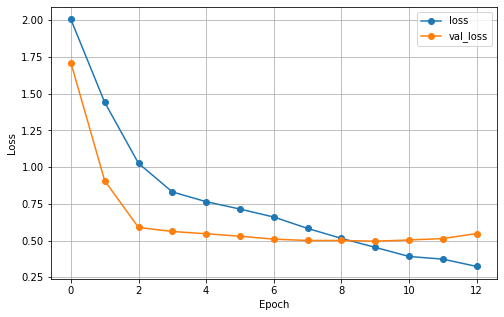

In [69]:
plt.plot(cnn.history['loss'], label='loss', marker = 'o')
plt.plot(cnn.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN Classification

In [70]:
cnn_pred = np.round(model.predict(X_test_final))

25/25 [==============================] - 0s 5ms/step


In [71]:
print('Accuracy %s' % accuracy_score(y_test, cnn_pred))
print('F1-score %s' % f1_score(y_test, cnn_pred, zero_division=1, average=None))
print('Classification report:')
print(classification_report(y_test, cnn_pred, zero_division=1))

Accuracy 0.8087291399229781
F1-score [0.45689655 0.89111969 0.         0.         0.         0.
 0.         0.         1.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.33      0.46       163
           1       0.83      0.97      0.89       597
           2       1.00      0.00      0.00        12
           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00         2
           5       1.00      0.00      0.00         2
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00         1
           8       1.00      1.00      1.00         0

   micro avg       0.82      0.81      0.82       779
   macro avg       0.95      0.25      0.26       779
weighted avg       0.82      0.81      0.78       779
 samples avg       0.82      0.81      0.81       779



#Classification with Word2Vec

In [72]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [73]:
pip install --upgrade gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 2.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [74]:
import gensim
from gensim.models import Word2Vec

In [75]:
df_es['Genre_number'] = df_es['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in df_es['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  if i == 'Indie':
   numbers.append(5)

  if i == 'R&B':
    numbers.append(6)
  
  if i == 'Electronic':
    numbers.append(7)
  
  elif i == 'Hip-Hop':
    numbers.append(8)

In [76]:
df_es['Genre_number'] = numbers

In [104]:
#Gensim word2vec requires sentences in input so i split the lyrics into sentences
sentence_splitter = nltk.data.load('tokenizers/punkt/spanish.pickle')
sentences =[]
sum=0
for lyrics in df_es['Lyrics']:
  sents = sentence_splitter.tokenize(lyrics.strip())
  sum+=len(sents)
  for sent in sents:
    sentences.append(sent.split())
print(sum)
print(len(sentences))

3892
3892


In [105]:
#checking that the sentences are in the correct format
for sent in sentences[:5]:
  print(sent, "\n")

['podría', 'permanecer', 'despierto', 'sólo', 'para', 'escucharte', 'respirar', 'mirarte', 'sonreír', 'mientras', 'duermes', 'a', 'lo', 'lejos', 'y', 'soñando', 'podría', 'pasar', 'mi', 'vida', 'en', 'esta', 'dulce', 'claudicación', 'podría', 'quedarme', 'perdido', 'en', 'este', 'momento', 'para', 'siempre', 'ya', 'que', 'cada', 'momento', 'que', 'pasé', 'contigo', 'es', 'un', 'momento', 'que', 'valoro', 'mucho', 'no', 'quiero', 'cerrar', 'los', 'ojos', 'no', 'quiero', 'quedarme', 'dormido', 'porque', 'te', 'extrañaría', 'nena', 'y', 'no', 'quiero', 'extrañar', 'nada', 'porque', 'aún', 'si', 'soñara', 'contigo', 'el', 'más', 'dulce', 'de', 'los', 'sueños', 'no', 'alcanzará', 'aún', 'así', 'te', 'extrañaría', 'nena', 'y', 'no', 'quiero', 'extrañar', 'nada', 'acostado', 'cerca', 'de', 'ti', 'siento', 'latir', 'tu', 'corazón', 'y', 'me', 'pregunto', 'con', 'qué', 'estás', 'soñando', 'me', 'pregunto', 'si', 'será', 'conmigo', 'luego', 'beso', 'tus', 'ojos', 'y', 'agradezco', 'a', 'dios', '

In [106]:
#creating the w2v embeddings
w2v_model=gensim.models.Word2Vec(sentences=sentences, vector_size=300, window=10, min_count=1)

In [107]:
w2v_model.train(sentences, epochs=10, total_examples=len(sentences))

(6474996, 8915510)

In [108]:
#total num of extracted words
vocab = w2v_model.wv.index_to_key
print("Total number of words: ", len(vocab))

Total number of words:  30782


In [109]:
w2v_model.wv.most_similar('dos')

[('estemos', 0.49066248536109924),
 ('somos', 0.48301804065704346),
 ('cometimos', 0.45646366477012634),
 ('corazones', 0.4561023712158203),
 ('garantías', 0.44898444414138794),
 ('kisas', 0.44886115193367004),
 ('rezare', 0.44803446531295776),
 ('enamorados', 0.4465203881263733),
 ('¿acaso', 0.4412941336631775),
 ('cometidos', 0.4362698495388031)]

In [110]:
#creating a dictionary with words in vocab and their embeddings. It will be used to create the embedding matrix 

word_vec_dict={}

for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)

len(word_vec_dict)

30782

In [111]:
#finding the max length of the lyrics
maxi = -1
for i, lyrics in enumerate(df_es['Lyrics']):
  tokens=lyrics.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)

print(maxi)

1172


In [112]:
#integer encoding the words in the lyrics using Keras Tokenizer
tok=Tokenizer()
tok.fit_on_texts(df_es['Lyrics'])
vocab_size = len(tok.word_index) +1
encoded_lyrics = tok.texts_to_sequences(df_es['Lyrics'])

In [113]:
max_lyrics_len=maxi
embed_dim = 300

#padding every sequence to the max length
padded_lyrics=pad_sequences(encoded_lyrics, maxlen=max_lyrics_len, padding='post')
padded_lyrics.shape

(3892, 1172)

In [114]:
#creating the embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word, i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None: #if the word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
    #if the word is not found, the vector corresponding to the embedding will be filled with zeros

In [115]:
Y= to_categorical(df_es['Genre_number'], 9) #transforming the labels into one hot vectors
x_train,x_test,y_train,y_test=train_test_split(padded_lyrics, Y,test_size=0.20,random_state=42)

In [116]:
y_train.shape, y_test.shape

((3113, 9), (779, 9))

#LSTM Classification with Word2Vec

In [117]:
from keras.initializers import Constant


In [118]:
epochs=5
batch_size=64

In [119]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable=False, embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(20, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1172, 300)         9225900   
                                                                 
 lstm_2 (LSTM)               (None, 20)                25680     
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                672       
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 9)                 297       
                                                                 
Total params: 9,252,549
Trainable params: 26,649
Non-t

In [120]:
lstm_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
39/39 [==============================] - 108s 3s/step - loss: 1.5192 - accuracy: 0.7723 - val_loss: 0.7699 - val_accuracy: 0.8074
Epoch 2/5
39/39 [==============================] - 103s 3s/step - loss: 0.7433 - accuracy: 0.7871 - val_loss: 0.6112 - val_accuracy: 0.8074
Epoch 3/5
39/39 [==============================] - 104s 3s/step - loss: 0.6692 - accuracy: 0.7871 - val_loss: 0.5887 - val_accuracy: 0.8074
Epoch 4/5
39/39 [==============================] - 101s 3s/step - loss: 0.6597 - accuracy: 0.7871 - val_loss: 0.5800 - val_accuracy: 0.8074
Epoch 5/5
39/39 [==============================] - 104s 3s/step - loss: 0.6506 - accuracy: 0.7871 - val_loss: 0.5773 - val_accuracy: 0.8074


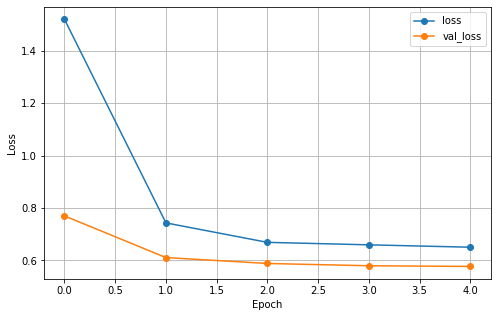

In [121]:
plt.plot(lstm_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(lstm_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM classification with w2v

In [122]:
lstmW2V_pred = np.round(model.predict(x_test)) #x_test from last padding and train/test splitting

25/25 [==============================] - 5s 193ms/step


In [123]:
print('Accuracy %s' % accuracy_score(y_test, lstmW2V_pred))
print('F1-score %s' % f1_score(y_test, lstmW2V_pred, zero_division=1, average=None))
print('Classification report:')
print(classification_report(y_test, lstmW2V_pred, zero_division=1))

Accuracy 0.7432605905006419
F1-score [0.         0.85272459 0.         1.         0.         0.
 0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       176
           1       0.74      1.00      0.85       579
           2       1.00      0.00      0.00        15
           3       1.00      1.00      1.00         0
           4       1.00      0.00      0.00         4
           5       1.00      0.00      0.00         1
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00         2
           8       1.00      0.00      0.00         1

   micro avg       0.74      0.74      0.74       779
   macro avg       0.97      0.22      0.21       779
weighted avg       0.81      0.74      0.63       779
 samples avg       0.74      0.74      0.74       779



#CNN Classification with Word2Vec

In [124]:
filters=10
kernel_size=3
epochs=20

In [125]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable=False, embeddings_initializer=Constant(embed_matrix)))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1172, 300)         9225900   
                                                                 
 conv1d_2 (Conv1D)           (None, 1170, 10)          9010      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                352       
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                      

In [126]:
cnn_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
39/39 [==============================] - 13s 328ms/step - loss: 1.0506 - accuracy: 0.6980 - val_loss: 0.5720 - val_accuracy: 0.8074
Epoch 2/20
39/39 [==============================] - 12s 321ms/step - loss: 0.7026 - accuracy: 0.7735 - val_loss: 0.5550 - val_accuracy: 0.8074
Epoch 3/20
39/39 [==============================] - 12s 319ms/step - loss: 0.6717 - accuracy: 0.7811 - val_loss: 0.5945 - val_accuracy: 0.8074
Epoch 4/20
39/39 [==============================] - 12s 321ms/step - loss: 0.6475 - accuracy: 0.7859 - val_loss: 0.5796 - val_accuracy: 0.8074
Epoch 5/20
39/39 [==============================] - 12s 320ms/step - loss: 0.6266 - accuracy: 0.7863 - val_loss: 0.5535 - val_accuracy: 0.8074
Epoch 6/20
39/39 [==============================] - 12s 318ms/step - loss: 0.6174 - accuracy: 0.7863 - val_loss: 0.5749 - val_accuracy: 0.8074
Epoch 7/20
39/39 [==============================] - 12s 319ms/step - loss: 0.6144 - accuracy: 0.7876 - val_loss: 0.5832 - val_accuracy: 0.8074

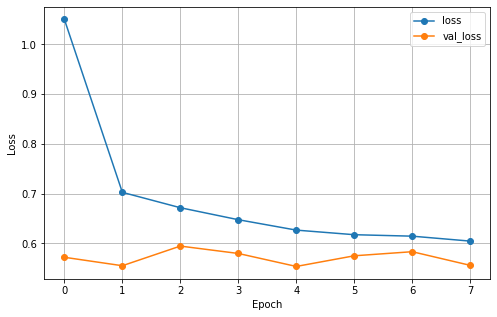

In [127]:
plt.plot(cnn_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(cnn_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN classification with w2v

In [128]:
cnnW2V_pred = np.round(model.predict(x_test))

25/25 [==============================] - 1s 45ms/step


In [129]:
print('Accuracy %s' % accuracy_score(y_test, cnnW2V_pred))
print('F1-score %s' % f1_score(y_test, cnnW2V_pred, average=None, zero_division=1))
print('Classification report:')
print(classification_report(y_test, cnnW2V_pred, zero_division=1))

Accuracy 0.7432605905006419
F1-score [0.         0.85650888 0.         1.         0.         0.
 0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       176
           1       0.75      1.00      0.86       579
           2       1.00      0.00      0.00        15
           3       1.00      1.00      1.00         0
           4       1.00      0.00      0.00         4
           5       1.00      0.00      0.00         1
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00         2
           8       1.00      0.00      0.00         1

   micro avg       0.75      0.74      0.75       779
   macro avg       0.97      0.22      0.21       779
weighted avg       0.81      0.74      0.64       779
 samples avg       0.75      0.74      0.74       779

